In [1]:
# Import Cell

import pandas as pd
import datetime
import pprint as pp
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from scipy import stats
from sklearn.metrics import r2_score
import numpy as np
from datetime import datetime
date_format = "%Y-%m-%d"
from tqdm import tqdm
from sklearn.svm import SVC
import matplotlib.pyplot as plt

In [13]:
# Data Prep

df = pd.read_csv('../data/outputs/final_norm.csv')
df1 = pd.read_csv('../data/outputs/ranks.csv')
game_id = df1[['GAME_ID_HOME']]

df1_norm = df1.drop(['GAME_ID_HOME'],axis=1)
df1_norm = (df1_norm - df1_norm.mean()) / (df1_norm.max() - df1_norm.min())
df1 = pd.concat([game_id, df1_norm], axis=1)
df = pd.merge(df, df1, left_on=['CURRENT_GAME_ID'], right_on=['GAME_ID_HOME'])
df = df.drop_duplicates()

train_start_date = datetime.strptime("2016-10-26", date_format)
train_end_date = datetime.strptime("2017-10-17", date_format)
test_date = datetime.strptime("2017-10-18", date_format)

# Full Season
#date_list = list(df["GAME_DATE_EST"][0:1210].drop_duplicates())

# Fraction of Season
date_list = sorted(list(df["GAME_DATE_EST"][0:400].drop_duplicates()), reverse=True)

# Date training data extends back to
train_end_val = "2016-10-28"

test_end_index = int(df.index[df['GAME_DATE_EST'] == "2018-04-10"][-1])
test_start_index = int(df.index[df['GAME_DATE_EST'] == "2018-04-10"][0])
train_end_index = int(df.index[df['GAME_DATE_EST'] == "2016-10-26"][-1])
train_start_index = int(df.index[df['GAME_DATE_EST'] == "2018-04-10"][0])

temp = pd.get_dummies(df[['TEAM_NAME_AWAY']])
df = df.drop(columns=['TEAM_NAME_AWAY'])
df = pd.concat([df, temp], axis=1)

temp = pd.get_dummies(df[['TEAM_NAME_HOME']])
df = df.drop(columns=['TEAM_NAME_HOME'])
df = pd.concat([df, temp], axis=1)
df = df.drop(['CURRENT_GAME_ID', 'GAME_ID_HOME'],axis=1)

In [3]:
# Functions

def executeCLF(clf, x_train, y_train, x_test, y_test):
    test_preds = clf.predict(x_test.values)
    train_preds = clf.predict(x_train.values)
    return pd.DataFrame({'PREDICTION': test_preds}), accuracy_score(y_test, test_preds)

def printDetailedPreds(preds_df, y_test):
    detailed_preds = pd.concat([preds_df.reset_index(drop=True), y_test.reset_index(drop=True)])
    return detailed_preds

In [22]:
# Predicting one day at a time - Logistic Regression
accuracies = []
games_per_day = []
total_games = 0

# These were selected in our other notebook through backwards greedy selection
selected_features = ['NET_RTG_HOME', 'NET_RTG_AWAY', 'WIN_PERCENTAGE_A',
                     'WIN_PERCENTAGE_B','DAYS_SINCE_LAST_GAME_A', 'DAYS_SINCE_LAST_GAME_B',
                     'EXPERT_RANK_HOME','EXPERT_RANK_AWAY']

for date in tqdm(date_list):
    test_end = int(df.index[df['GAME_DATE_EST'] == date][-1])
    test_start = int(df.index[df['GAME_DATE_EST'] == date][0])
    train_end = int(df.index[df['GAME_DATE_EST'] == train_end_val][-1])
    train_start = int(df.index[df['GAME_DATE_EST'] == date][-1] + 1)
    
    games = test_end - test_start
    total_games += games
    games_per_day.append(games)
    
    temp = df['GAME_DATE_EST']
    df = df.drop(['GAME_DATE_EST'],axis=1)
    
    y = df['WIN_HOME']
    x = df[selected_features]
    #x = df.drop(columns=['WIN_HOME'])
    
    if test_start == test_end:
        x_train, x_test = x.iloc[train_start:train_end], x.iloc[[test_start]]
        y_train, y_test = y.iloc[train_start:train_end], y.iloc[[test_start]]
    elif train_start == train_end:
        x_train, x_test = x.iloc[[train_start]], x.iloc[test_start:test_end]
        y_train, y_test = y.iloc[[train_start]], y.iloc[test_start:test_end]
    else:
        x_train, x_test = x.iloc[train_start:train_end], x.iloc[test_start:test_end]
        y_train, y_test = y.iloc[train_start:train_end], y.iloc[test_start:test_end]
    
    rf_reg = LogisticRegression(solver='lbfgs').fit(x_train.values, y_train.values)

    rf_preds_df, accuracy = executeCLF(rf_reg, x_train, y_train, x_test, y_test)
    accuracies.append(accuracy * games)
        
    df["GAME_DATE_EST"] = temp

print("\nResults for Logistic Regression model:") 
print(np.sum(accuracies)/total_games)



100%|██████████| 54/54 [00:01<00:00, 45.36it/s]


Results for Logistic Regression model:
0.673352435530086


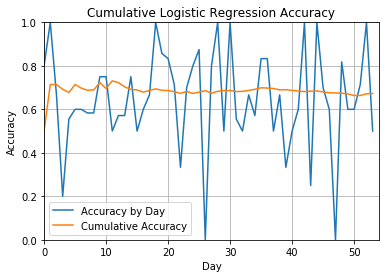

In [5]:
# Make Accuracy Graph
plt.title("Logistic Regression Accuracy by Day")
plt.xlabel("Day")
plt.ylabel("Accuracy by Day")
plt.axis([0, len(games_per_day) , 0, 1 ])
plt.plot(np.array(accuracies)/np.array(games_per_day), label="Accuracy by Day")
plt.legend()
plt.grid(True)

accuracies = accuracies[::-1]
games_per_day = games_per_day[::-1]
cum_acc = np.cumsum(np.array(accuracies))/np.cumsum(np.array(games_per_day))
plt.title("Cumulative Logistic Regression Accuracy")
plt.xlabel("Day")
plt.ylabel("Accuracy")
plt.axis([0, len(games_per_day) , 0, 1 ])
plt.plot(cum_acc, label="Cumulative Accuracy")
plt.legend()
plt.grid(True)


In [23]:
# Predicting one day at a time - Random Forest
accuracies = []
games_per_day = []
total_games = 0
for date in tqdm(date_list):
    test_end = int(df.index[df['GAME_DATE_EST'] == date][-1])
    test_start = int(df.index[df['GAME_DATE_EST'] == date][0])
    train_end = int(df.index[df['GAME_DATE_EST'] == train_end_val][-1])
    train_start = int(df.index[df['GAME_DATE_EST'] == date][-1] + 1)
    
    games = test_end - test_start
    total_games += games
    games_per_day.append(games)
    
    temp = df['GAME_DATE_EST']
    df = df.drop(['GAME_DATE_EST'],axis=1)
    
    y = df['WIN_HOME']
    x = df.drop(columns=['WIN_HOME'])
    
    if test_start == test_end:
        x_train, x_test = x.iloc[train_start:train_end], x.iloc[[test_start]]
        y_train, y_test = y.iloc[train_start:train_end], y.iloc[[test_start]]
    elif train_start == train_end:
        x_train, x_test = x.iloc[[train_start]], x.iloc[test_start:test_end]
        y_train, y_test = y.iloc[[train_start]], y.iloc[test_start:test_end]
    else:
        x_train, x_test = x.iloc[train_start:train_end], x.iloc[test_start:test_end]
        y_train, y_test = y.iloc[train_start:train_end], y.iloc[test_start:test_end]
    
    #rf_reg = LogisticRegression(solver='lbfgs')
    #rf_reg = AdaBoostClassifier(n_estimators=20)
    rf_reg = RandomForestClassifier(n_estimators=100, max_depth=11).fit(x_train.values, y_train.values)

    rf_preds_df, accuracy = executeCLF(rf_reg, x_train, y_train, x_test, y_test)
    accuracies.append(accuracy * games)
        
    df["GAME_DATE_EST"] = temp

print("\nResults for Random Forest model:") 
print(np.sum(accuracies)/total_games)

100%|██████████| 54/54 [00:14<00:00,  4.13it/s]


Results for Random Forest model:
0.670487106017192


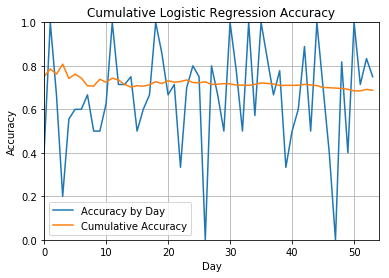

In [7]:
plt.title("Logistic Regression Accuracy by Day")
plt.xlabel("Day")
plt.ylabel("Accuracy by Day")
plt.axis([0, len(games_per_day) , 0, 1 ])
plt.plot(np.array(accuracies)/np.array(games_per_day), label="Accuracy by Day")
plt.legend()
plt.grid(True)

accuracies = accuracies[::-1]
games_per_day = games_per_day[::-1]
cum_acc = np.cumsum(np.array(accuracies))/np.cumsum(np.array(games_per_day))
plt.title("Cumulative Logistic Regression Accuracy")
plt.xlabel("Day")
plt.ylabel("Accuracy")
plt.axis([0, len(games_per_day) , 0, 1 ])
plt.plot(cum_acc, label="Cumulative Accuracy")
plt.legend()
plt.grid(True)

In [16]:
# Predicting one day at a time - Random Forest
accuracies = []
games_per_day = []
total_games = 0
for date in tqdm(date_list):
    test_end = int(df.index[df['GAME_DATE_EST'] == date][-1])
    test_start = int(df.index[df['GAME_DATE_EST'] == date][0])
    train_end = int(df.index[df['GAME_DATE_EST'] == train_end_val][-1])
    train_start = int(df.index[df['GAME_DATE_EST'] == date][-1] + 1)
    
    games = test_end - test_start
    total_games += games
    games_per_day.append(games)
    
    temp = df['GAME_DATE_EST']
    df = df.drop(['GAME_DATE_EST'],axis=1)
    
    y = df['WIN_HOME']
    x = df.drop(columns=['WIN_HOME'])
    
    if test_start == test_end:
        x_train, x_test = x.iloc[train_start:train_end], x.iloc[[test_start]]
        y_train, y_test = y.iloc[train_start:train_end], y.iloc[[test_start]]
    elif train_start == train_end:
        x_train, x_test = x.iloc[[train_start]], x.iloc[test_start:test_end]
        y_train, y_test = y.iloc[[train_start]], y.iloc[test_start:test_end]
    else:
        x_train, x_test = x.iloc[train_start:train_end], x.iloc[test_start:test_end]
        y_train, y_test = y.iloc[train_start:train_end], y.iloc[test_start:test_end]
    
    #rf_reg = LogisticRegression(solver='lbfgs')
    rf_reg = AdaBoostClassifier(n_estimators=10).fit(x_train.values, y_train.values)
    #rf_reg = RandomForestClassifier(n_estimators=20, max_depth=11)

    rf_preds_df, accuracy = executeCLF(rf_reg, x_train, y_train, x_test, y_test)
    accuracies.append(accuracy * games)
        
    df["GAME_DATE_EST"] = temp

print("\nResults AdaBoost model:") 
print(np.sum(accuracies)/total_games)

100%|██████████| 54/54 [00:02<00:00, 21.04it/s]


Results AdaBoost model:
0.6876790830945558


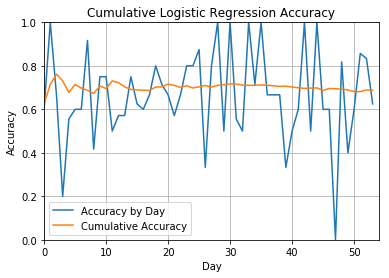

In [9]:
plt.title("Logistic Regression Accuracy by Day")
plt.xlabel("Day")
plt.ylabel("Accuracy by Day")
plt.axis([0, len(games_per_day) , 0, 1 ])
plt.plot(np.array(accuracies)/np.array(games_per_day), label="Accuracy by Day")
plt.legend()
plt.grid(True)

accuracies = accuracies[::-1]
games_per_day = games_per_day[::-1]
cum_acc = np.cumsum(np.array(accuracies))/np.cumsum(np.array(games_per_day))
plt.title("Cumulative Logistic Regression Accuracy")
plt.xlabel("Day")
plt.ylabel("Accuracy")
plt.axis([0, len(games_per_day) , 0, 1 ])
plt.plot(cum_acc, label="Cumulative Accuracy")
plt.legend()
plt.grid(True)

In [10]:
# Predicting one day at a time - Random Forest
accuracies = []
games_per_day = []
total_games = 0
for date in tqdm(date_list):
    test_end = int(df.index[df['GAME_DATE_EST'] == date][-1])
    test_start = int(df.index[df['GAME_DATE_EST'] == date][0])
    train_end = int(df.index[df['GAME_DATE_EST'] == train_end_val][-1])
    train_start = int(df.index[df['GAME_DATE_EST'] == date][-1] + 1)
    
    games = test_end - test_start
    total_games += games
    games_per_day.append(games)
    
    temp = df['GAME_DATE_EST']
    df = df.drop(['GAME_DATE_EST'],axis=1)
    
    y = df['WIN_HOME']
    x = df.drop(columns=['WIN_HOME'])
    
    if test_start == test_end:
        x_train, x_test = x.iloc[train_start:train_end], x.iloc[[test_start]]
        y_train, y_test = y.iloc[train_start:train_end], y.iloc[[test_start]]
    elif train_start == train_end:
        x_train, x_test = x.iloc[[train_start]], x.iloc[test_start:test_end]
        y_train, y_test = y.iloc[[train_start]], y.iloc[test_start:test_end]
    else:
        x_train, x_test = x.iloc[train_start:train_end], x.iloc[test_start:test_end]
        y_train, y_test = y.iloc[train_start:train_end], y.iloc[test_start:test_end]
    
    svc = SVC(gamma='auto').fit(x_train.values, y_train.values)

    rf_preds_df, accuracy = executeCLF(svc, x_train, y_train, x_test, y_test)
    accuracies.append(accuracy * games)
        
    df["GAME_DATE_EST"] = temp

print("\nResults SVC model:") 
print(np.sum(accuracies)/total_games)

100%|██████████| 54/54 [01:44<00:00,  1.73s/it]


Results SVC model:
0.6532951289398281


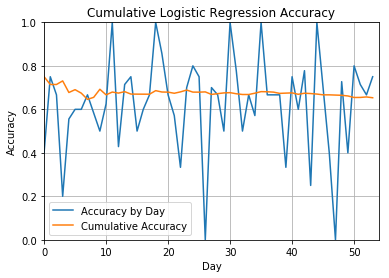

In [11]:
plt.title("Logistic Regression Accuracy by Day")
plt.xlabel("Day")
plt.ylabel("Accuracy by Day")
plt.axis([0, len(games_per_day) , 0, 1 ])
plt.plot(np.array(accuracies)/np.array(games_per_day), label="Accuracy by Day")
plt.legend()
plt.grid(True)

accuracies = accuracies[::-1]
games_per_day = games_per_day[::-1]
cum_acc = np.cumsum(np.array(accuracies))/np.cumsum(np.array(games_per_day))
plt.title("Cumulative Logistic Regression Accuracy")
plt.xlabel("Day")
plt.ylabel("Accuracy")
plt.axis([0, len(games_per_day) , 0, 1 ])
plt.plot(cum_acc, label="Cumulative Accuracy")
plt.legend()
plt.grid(True)